# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

AttributeError: 'numpy.ndarray' object has no attribute 'mask'

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

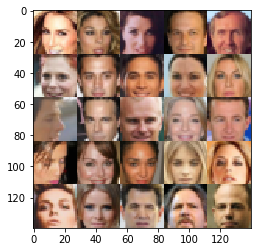

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):
        alpha = 0.2
        layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer1 = tf.maximum(layer1*alpha, layer1)
        layer1 = tf.nn.dropout(layer1, keep_prob=0.8)
        
        layer2 = tf.layers.conv2d(layer1, 128, 5, strides=2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer2 = tf.layers.batch_normalization(layer2, training=True)
        layer2 = tf.maximum(layer2*alpha, layer2)
        layer2 = tf.nn.dropout(layer2, keep_prob=0.8)
        
        layer3 = tf.layers.conv2d(layer2, 256, 5, 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        layer3 = tf.layers.batch_normalization(layer3, training=True)
        layer3 = tf.maximum(layer3*alpha, layer3)
        layer3 = tf.nn.dropout(layer3, keep_prob=0.8)
        
        flatten = tf.reshape(layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [30]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not(is_train)):
        alpha = 0.1
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.7)
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides = 1, padding='valid', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.7)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides = 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.7)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 2, padding='same', kernel_initializer=tf.contrib.layers.xavier_initializer())
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9
                                               ))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [37]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                batch_images = batch_images * 2.0
                
                sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps%10 == 0:
                    d_loss_train = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    g_loss_train = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(d_loss_train),
                         "Generator Loss: {:.4f}".format(g_loss_train))
                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [38]:
batch_size = 64
z_dim = 128
learning_rate = 0.0003
beta1 = 0.25


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

Epoch 1/2... Discriminator Loss: 2.2814 Generator Loss: 2.8280
Epoch 1/2... Discriminator Loss: 2.0084 Generator Loss: 3.4049
Epoch 1/2... Discriminator Loss: 2.0872 Generator Loss: 4.5534
Epoch 1/2... Discriminator Loss: 1.4053 Generator Loss: 0.6856
Epoch 1/2... Discriminator Loss: 1.5437 Generator Loss: 6.5561
Epoch 1/2... Discriminator Loss: 1.4634 Generator Loss: 0.4894
Epoch 1/2... Discriminator Loss: 0.7138 Generator Loss: 1.8044
Epoch 1/2... Discriminator Loss: 0.7829 Generator Loss: 1.2942
Epoch 1/2... Discriminator Loss: 1.2514 Generator Loss: 0.9430
Epoch 1/2... Discriminator Loss: 1.6953 Generator Loss: 0.6621


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 0.9666 Generator Loss: 1.6618
Epoch 1/2... Discriminator Loss: 0.8025 Generator Loss: 1.8181
Epoch 1/2... Discriminator Loss: 1.1389 Generator Loss: 1.0911
Epoch 1/2... Discriminator Loss: 0.9273 Generator Loss: 2.6126
Epoch 1/2... Discriminator Loss: 0.8579 Generator Loss: 2.3536
Epoch 1/2... Discriminator Loss: 1.2136 Generator Loss: 0.7981
Epoch 1/2... Discriminator Loss: 1.5468 Generator Loss: 3.7658
Epoch 1/2... Discriminator Loss: 0.7781 Generator Loss: 2.1117
Epoch 1/2... Discriminator Loss: 0.9799 Generator Loss: 1.3916
Epoch 1/2... Discriminator Loss: 1.1975 Generator Loss: 1.3702


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1335 Generator Loss: 1.9310
Epoch 1/2... Discriminator Loss: 1.1860 Generator Loss: 1.1255
Epoch 1/2... Discriminator Loss: 1.5181 Generator Loss: 0.5734
Epoch 1/2... Discriminator Loss: 1.4125 Generator Loss: 0.6317
Epoch 1/2... Discriminator Loss: 1.0845 Generator Loss: 1.2312
Epoch 1/2... Discriminator Loss: 1.1452 Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 1.0465 Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 1.4043 Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 1.2187 Generator Loss: 1.1040
Epoch 1/2... Discriminator Loss: 1.2825 Generator Loss: 0.7872


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1254 Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.2657 Generator Loss: 0.7954
Epoch 1/2... Discriminator Loss: 0.9950 Generator Loss: 1.0908
Epoch 1/2... Discriminator Loss: 1.0790 Generator Loss: 1.1165
Epoch 1/2... Discriminator Loss: 1.0594 Generator Loss: 1.1088
Epoch 1/2... Discriminator Loss: 1.1088 Generator Loss: 1.6953
Epoch 1/2... Discriminator Loss: 0.9965 Generator Loss: 1.4942
Epoch 1/2... Discriminator Loss: 0.9159 Generator Loss: 1.4419
Epoch 1/2... Discriminator Loss: 1.1837 Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.5253 Generator Loss: 0.5487


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1419 Generator Loss: 1.5227
Epoch 1/2... Discriminator Loss: 1.1308 Generator Loss: 1.0002
Epoch 1/2... Discriminator Loss: 1.0916 Generator Loss: 0.9578
Epoch 1/2... Discriminator Loss: 1.1097 Generator Loss: 1.9305
Epoch 1/2... Discriminator Loss: 1.0140 Generator Loss: 1.2926
Epoch 1/2... Discriminator Loss: 1.1907 Generator Loss: 0.7876
Epoch 1/2... Discriminator Loss: 1.1341 Generator Loss: 1.4173
Epoch 1/2... Discriminator Loss: 1.1422 Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.1608 Generator Loss: 1.2630
Epoch 1/2... Discriminator Loss: 1.0963 Generator Loss: 1.2342


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.4429 Generator Loss: 1.9271
Epoch 1/2... Discriminator Loss: 1.0315 Generator Loss: 1.2327
Epoch 1/2... Discriminator Loss: 1.1426 Generator Loss: 1.4870
Epoch 1/2... Discriminator Loss: 1.0961 Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 1.1579 Generator Loss: 1.7642
Epoch 1/2... Discriminator Loss: 1.2048 Generator Loss: 0.9032
Epoch 1/2... Discriminator Loss: 1.5393 Generator Loss: 0.5503
Epoch 1/2... Discriminator Loss: 1.0805 Generator Loss: 1.4651
Epoch 1/2... Discriminator Loss: 1.2179 Generator Loss: 0.7908
Epoch 1/2... Discriminator Loss: 1.0651 Generator Loss: 0.9502


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1359 Generator Loss: 1.0312
Epoch 1/2... Discriminator Loss: 1.3094 Generator Loss: 1.8997
Epoch 1/2... Discriminator Loss: 1.2320 Generator Loss: 0.6361
Epoch 1/2... Discriminator Loss: 1.1315 Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.0165 Generator Loss: 0.9958
Epoch 1/2... Discriminator Loss: 1.4373 Generator Loss: 0.5462
Epoch 1/2... Discriminator Loss: 1.1134 Generator Loss: 1.1804
Epoch 1/2... Discriminator Loss: 1.2571 Generator Loss: 0.8085
Epoch 1/2... Discriminator Loss: 1.1117 Generator Loss: 0.9858
Epoch 1/2... Discriminator Loss: 1.1154 Generator Loss: 1.2286


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.2307 Generator Loss: 1.0223
Epoch 1/2... Discriminator Loss: 1.1320 Generator Loss: 1.5571
Epoch 1/2... Discriminator Loss: 1.1283 Generator Loss: 1.2152
Epoch 1/2... Discriminator Loss: 1.1353 Generator Loss: 1.6430
Epoch 1/2... Discriminator Loss: 0.9156 Generator Loss: 1.4549
Epoch 1/2... Discriminator Loss: 1.1785 Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.0721 Generator Loss: 1.4869
Epoch 1/2... Discriminator Loss: 1.2586 Generator Loss: 1.7329
Epoch 1/2... Discriminator Loss: 1.0522 Generator Loss: 1.2394
Epoch 1/2... Discriminator Loss: 1.0527 Generator Loss: 1.1011


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.3002 Generator Loss: 0.6626
Epoch 1/2... Discriminator Loss: 1.2602 Generator Loss: 0.7694
Epoch 1/2... Discriminator Loss: 1.1833 Generator Loss: 1.0240
Epoch 1/2... Discriminator Loss: 0.8327 Generator Loss: 1.5508
Epoch 1/2... Discriminator Loss: 1.0488 Generator Loss: 1.4225
Epoch 1/2... Discriminator Loss: 1.4561 Generator Loss: 0.5362
Epoch 1/2... Discriminator Loss: 1.2469 Generator Loss: 1.4401
Epoch 1/2... Discriminator Loss: 1.1018 Generator Loss: 1.3331
Epoch 1/2... Discriminator Loss: 1.0730 Generator Loss: 1.3862
Epoch 1/2... Discriminator Loss: 1.0899 Generator Loss: 1.0363


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 1/2... Discriminator Loss: 1.1828 Generator Loss: 0.7822
Epoch 1/2... Discriminator Loss: 1.1393 Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.2108 Generator Loss: 1.1778
Epoch 2/2... Discriminator Loss: 1.1342 Generator Loss: 0.9094
Epoch 2/2... Discriminator Loss: 1.2227 Generator Loss: 0.7645
Epoch 2/2... Discriminator Loss: 1.0523 Generator Loss: 1.0248
Epoch 2/2... Discriminator Loss: 1.2838 Generator Loss: 1.7048
Epoch 2/2... Discriminator Loss: 1.1284 Generator Loss: 1.3591
Epoch 2/2... Discriminator Loss: 1.0646 Generator Loss: 1.4301
Epoch 2/2... Discriminator Loss: 1.0455 Generator Loss: 1.3544


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.0435 Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.9794 Generator Loss: 1.5350
Epoch 2/2... Discriminator Loss: 1.1749 Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.2492 Generator Loss: 1.5591
Epoch 2/2... Discriminator Loss: 1.1053 Generator Loss: 1.6386
Epoch 2/2... Discriminator Loss: 1.1706 Generator Loss: 1.2669
Epoch 2/2... Discriminator Loss: 1.1629 Generator Loss: 0.6662
Epoch 2/2... Discriminator Loss: 1.1296 Generator Loss: 0.8907
Epoch 2/2... Discriminator Loss: 1.0452 Generator Loss: 1.6926
Epoch 2/2... Discriminator Loss: 1.0920 Generator Loss: 0.9272


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9796 Generator Loss: 1.3139
Epoch 2/2... Discriminator Loss: 0.9575 Generator Loss: 1.0451
Epoch 2/2... Discriminator Loss: 0.9629 Generator Loss: 1.1914
Epoch 2/2... Discriminator Loss: 1.0874 Generator Loss: 1.1374
Epoch 2/2... Discriminator Loss: 1.0896 Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 1.0115 Generator Loss: 1.3642
Epoch 2/2... Discriminator Loss: 0.9881 Generator Loss: 1.6041
Epoch 2/2... Discriminator Loss: 1.0786 Generator Loss: 0.9531
Epoch 2/2... Discriminator Loss: 1.2265 Generator Loss: 0.6097
Epoch 2/2... Discriminator Loss: 1.0560 Generator Loss: 1.1313


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9364 Generator Loss: 1.6019
Epoch 2/2... Discriminator Loss: 1.0118 Generator Loss: 1.4639
Epoch 2/2... Discriminator Loss: 1.1616 Generator Loss: 0.7584
Epoch 2/2... Discriminator Loss: 1.0924 Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 1.1470 Generator Loss: 1.2149
Epoch 2/2... Discriminator Loss: 1.0798 Generator Loss: 1.7285
Epoch 2/2... Discriminator Loss: 1.0166 Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.1726 Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 1.0388 Generator Loss: 1.4583
Epoch 2/2... Discriminator Loss: 1.2315 Generator Loss: 1.7867


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9088 Generator Loss: 1.4875
Epoch 2/2... Discriminator Loss: 1.0569 Generator Loss: 1.5119
Epoch 2/2... Discriminator Loss: 1.0335 Generator Loss: 1.2490
Epoch 2/2... Discriminator Loss: 1.0949 Generator Loss: 1.6527
Epoch 2/2... Discriminator Loss: 1.0388 Generator Loss: 0.8493
Epoch 2/2... Discriminator Loss: 1.3430 Generator Loss: 0.6924
Epoch 2/2... Discriminator Loss: 1.0314 Generator Loss: 1.4845
Epoch 2/2... Discriminator Loss: 1.0727 Generator Loss: 0.7598
Epoch 2/2... Discriminator Loss: 0.9881 Generator Loss: 1.4161
Epoch 2/2... Discriminator Loss: 1.7260 Generator Loss: 2.0602


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.0941 Generator Loss: 1.2678
Epoch 2/2... Discriminator Loss: 0.9849 Generator Loss: 1.5234
Epoch 2/2... Discriminator Loss: 1.0176 Generator Loss: 1.0979
Epoch 2/2... Discriminator Loss: 0.9040 Generator Loss: 1.2327
Epoch 2/2... Discriminator Loss: 0.9848 Generator Loss: 1.2459
Epoch 2/2... Discriminator Loss: 1.2350 Generator Loss: 1.3414
Epoch 2/2... Discriminator Loss: 0.9769 Generator Loss: 1.2032
Epoch 2/2... Discriminator Loss: 1.0910 Generator Loss: 1.1792
Epoch 2/2... Discriminator Loss: 1.0344 Generator Loss: 0.9982
Epoch 2/2... Discriminator Loss: 0.8598 Generator Loss: 1.6498


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9950 Generator Loss: 1.4410
Epoch 2/2... Discriminator Loss: 1.1130 Generator Loss: 2.0244
Epoch 2/2... Discriminator Loss: 0.8988 Generator Loss: 1.6013
Epoch 2/2... Discriminator Loss: 0.8729 Generator Loss: 1.5515
Epoch 2/2... Discriminator Loss: 0.9568 Generator Loss: 1.5169
Epoch 2/2... Discriminator Loss: 1.0240 Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 1.0058 Generator Loss: 1.1181
Epoch 2/2... Discriminator Loss: 1.3610 Generator Loss: 1.9132
Epoch 2/2... Discriminator Loss: 1.0909 Generator Loss: 1.1418
Epoch 2/2... Discriminator Loss: 1.1775 Generator Loss: 0.8528


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.3172 Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 1.0537 Generator Loss: 1.7843
Epoch 2/2... Discriminator Loss: 0.8800 Generator Loss: 1.2515
Epoch 2/2... Discriminator Loss: 1.0765 Generator Loss: 0.8551
Epoch 2/2... Discriminator Loss: 0.9169 Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.8952 Generator Loss: 1.5891
Epoch 2/2... Discriminator Loss: 1.1321 Generator Loss: 1.1295
Epoch 2/2... Discriminator Loss: 0.8294 Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 0.9069 Generator Loss: 1.5001
Epoch 2/2... Discriminator Loss: 1.0900 Generator Loss: 0.8629


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 1.0191 Generator Loss: 1.1921
Epoch 2/2... Discriminator Loss: 0.9645 Generator Loss: 1.4562
Epoch 2/2... Discriminator Loss: 1.1633 Generator Loss: 0.9544
Epoch 2/2... Discriminator Loss: 0.9382 Generator Loss: 1.5468
Epoch 2/2... Discriminator Loss: 0.8275 Generator Loss: 1.4881
Epoch 2/2... Discriminator Loss: 0.9777 Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.9297 Generator Loss: 1.5633
Epoch 2/2... Discriminator Loss: 1.3576 Generator Loss: 0.6642
Epoch 2/2... Discriminator Loss: 0.7151 Generator Loss: 1.5666
Epoch 2/2... Discriminator Loss: 1.4523 Generator Loss: 1.6484


AttributeError: 'numpy.ndarray' object has no attribute 'mask'

Epoch 2/2... Discriminator Loss: 0.9771 Generator Loss: 1.0597
Epoch 2/2... Discriminator Loss: 1.0876 Generator Loss: 1.1235
Epoch 2/2... Discriminator Loss: 0.9242 Generator Loss: 1.2122
Epoch 2/2... Discriminator Loss: 1.1398 Generator Loss: 0.6509
Epoch 2/2... Discriminator Loss: 1.0496 Generator Loss: 1.4521
Epoch 2/2... Discriminator Loss: 1.0139 Generator Loss: 1.0276
Epoch 2/2... Discriminator Loss: 1.0156 Generator Loss: 1.4316


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7855 Generator Loss: 1.8674
Epoch 1/1... Discriminator Loss: 0.6786 Generator Loss: 1.8168
Epoch 1/1... Discriminator Loss: 0.6596 Generator Loss: 2.2266
Epoch 1/1... Discriminator Loss: 0.5250 Generator Loss: 2.6676
Epoch 1/1... Discriminator Loss: 0.6683 Generator Loss: 2.5286
Epoch 1/1... Discriminator Loss: 0.5663 Generator Loss: 2.7203
Epoch 1/1... Discriminator Loss: 0.4903 Generator Loss: 3.4188
Epoch 1/1... Discriminator Loss: 0.6087 Generator Loss: 2.3382
Epoch 1/1... Discriminator Loss: 0.7736 Generator Loss: 1.4505
Epoch 1/1... Discriminator Loss: 0.5369 Generator Loss: 3.0817


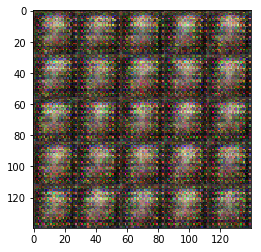

Epoch 1/1... Discriminator Loss: 0.5526 Generator Loss: 2.9039
Epoch 1/1... Discriminator Loss: 0.5677 Generator Loss: 2.7721
Epoch 1/1... Discriminator Loss: 0.5899 Generator Loss: 2.5631
Epoch 1/1... Discriminator Loss: 0.5538 Generator Loss: 2.8853
Epoch 1/1... Discriminator Loss: 0.7039 Generator Loss: 2.6799
Epoch 1/1... Discriminator Loss: 0.5040 Generator Loss: 3.0831
Epoch 1/1... Discriminator Loss: 0.5006 Generator Loss: 3.2387
Epoch 1/1... Discriminator Loss: 0.4424 Generator Loss: 3.9281
Epoch 1/1... Discriminator Loss: 0.4842 Generator Loss: 3.2199
Epoch 1/1... Discriminator Loss: 0.4321 Generator Loss: 3.4866


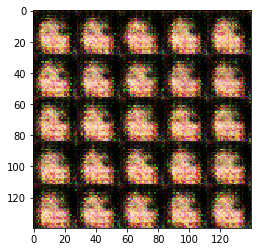

Epoch 1/1... Discriminator Loss: 0.5320 Generator Loss: 3.7974
Epoch 1/1... Discriminator Loss: 0.4654 Generator Loss: 3.1901
Epoch 1/1... Discriminator Loss: 0.5171 Generator Loss: 3.4505
Epoch 1/1... Discriminator Loss: 0.4959 Generator Loss: 3.8087
Epoch 1/1... Discriminator Loss: 0.4717 Generator Loss: 3.8184
Epoch 1/1... Discriminator Loss: 0.4239 Generator Loss: 3.7842
Epoch 1/1... Discriminator Loss: 0.4345 Generator Loss: 3.6080
Epoch 1/1... Discriminator Loss: 0.4362 Generator Loss: 3.5055
Epoch 1/1... Discriminator Loss: 0.4685 Generator Loss: 3.0298
Epoch 1/1... Discriminator Loss: 0.4433 Generator Loss: 3.8250


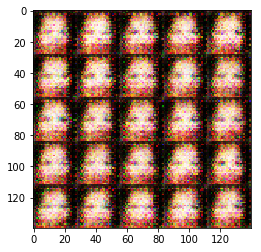

Epoch 1/1... Discriminator Loss: 0.4197 Generator Loss: 4.2080
Epoch 1/1... Discriminator Loss: 0.4558 Generator Loss: 3.7859
Epoch 1/1... Discriminator Loss: 0.4179 Generator Loss: 3.9762
Epoch 1/1... Discriminator Loss: 0.3875 Generator Loss: 4.7394
Epoch 1/1... Discriminator Loss: 0.4056 Generator Loss: 3.8885
Epoch 1/1... Discriminator Loss: 0.3904 Generator Loss: 4.0575
Epoch 1/1... Discriminator Loss: 0.3926 Generator Loss: 4.2486
Epoch 1/1... Discriminator Loss: 0.3853 Generator Loss: 4.3040
Epoch 1/1... Discriminator Loss: 0.3858 Generator Loss: 4.2998
Epoch 1/1... Discriminator Loss: 0.3763 Generator Loss: 4.5664


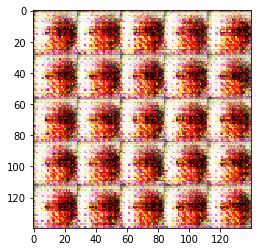

Epoch 1/1... Discriminator Loss: 0.3882 Generator Loss: 4.4811
Epoch 1/1... Discriminator Loss: 0.4085 Generator Loss: 4.2660
Epoch 1/1... Discriminator Loss: 0.3760 Generator Loss: 4.1844
Epoch 1/1... Discriminator Loss: 0.3890 Generator Loss: 3.8641
Epoch 1/1... Discriminator Loss: 0.3826 Generator Loss: 3.9219
Epoch 1/1... Discriminator Loss: 0.3614 Generator Loss: 5.2993
Epoch 1/1... Discriminator Loss: 0.3887 Generator Loss: 3.9016
Epoch 1/1... Discriminator Loss: 0.4317 Generator Loss: 3.0672
Epoch 1/1... Discriminator Loss: 0.4154 Generator Loss: 4.7919
Epoch 1/1... Discriminator Loss: 0.4104 Generator Loss: 4.0278


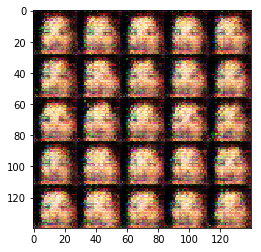

Epoch 1/1... Discriminator Loss: 0.4109 Generator Loss: 3.8746
Epoch 1/1... Discriminator Loss: 0.4473 Generator Loss: 3.9520
Epoch 1/1... Discriminator Loss: 0.6069 Generator Loss: 2.1161
Epoch 1/1... Discriminator Loss: 0.4892 Generator Loss: 3.6334
Epoch 1/1... Discriminator Loss: 0.5806 Generator Loss: 2.7160
Epoch 1/1... Discriminator Loss: 0.7062 Generator Loss: 2.5353
Epoch 1/1... Discriminator Loss: 0.5918 Generator Loss: 2.4318
Epoch 1/1... Discriminator Loss: 0.4922 Generator Loss: 3.1883
Epoch 1/1... Discriminator Loss: 0.5198 Generator Loss: 2.7981
Epoch 1/1... Discriminator Loss: 0.5864 Generator Loss: 2.4189


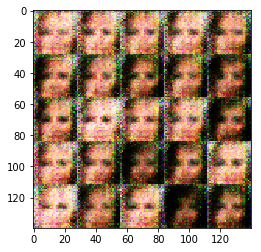

Epoch 1/1... Discriminator Loss: 0.4604 Generator Loss: 3.9518
Epoch 1/1... Discriminator Loss: 0.5929 Generator Loss: 4.7558
Epoch 1/1... Discriminator Loss: 0.4243 Generator Loss: 3.9296
Epoch 1/1... Discriminator Loss: 0.4607 Generator Loss: 3.3145
Epoch 1/1... Discriminator Loss: 0.4207 Generator Loss: 4.8378
Epoch 1/1... Discriminator Loss: 0.4084 Generator Loss: 3.7158
Epoch 1/1... Discriminator Loss: 0.3950 Generator Loss: 4.9152
Epoch 1/1... Discriminator Loss: 0.4089 Generator Loss: 4.3078
Epoch 1/1... Discriminator Loss: 0.5183 Generator Loss: 2.3006
Epoch 1/1... Discriminator Loss: 0.5627 Generator Loss: 2.2702


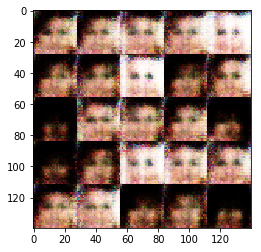

Epoch 1/1... Discriminator Loss: 0.4296 Generator Loss: 4.1038
Epoch 1/1... Discriminator Loss: 0.4600 Generator Loss: 4.0652
Epoch 1/1... Discriminator Loss: 0.4180 Generator Loss: 4.2449
Epoch 1/1... Discriminator Loss: 0.4135 Generator Loss: 4.1072
Epoch 1/1... Discriminator Loss: 0.4532 Generator Loss: 3.7956
Epoch 1/1... Discriminator Loss: 0.6019 Generator Loss: 2.1859
Epoch 1/1... Discriminator Loss: 0.4843 Generator Loss: 3.1539
Epoch 1/1... Discriminator Loss: 0.5009 Generator Loss: 2.8276
Epoch 1/1... Discriminator Loss: 0.5146 Generator Loss: 2.5250
Epoch 1/1... Discriminator Loss: 0.9229 Generator Loss: 1.3706


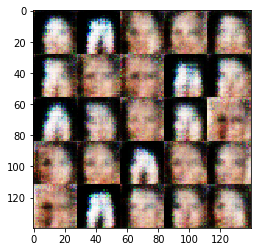

Epoch 1/1... Discriminator Loss: 0.6079 Generator Loss: 2.1142
Epoch 1/1... Discriminator Loss: 0.5098 Generator Loss: 3.0208
Epoch 1/1... Discriminator Loss: 0.5891 Generator Loss: 3.4165
Epoch 1/1... Discriminator Loss: 0.6684 Generator Loss: 2.3334
Epoch 1/1... Discriminator Loss: 0.5127 Generator Loss: 3.9487
Epoch 1/1... Discriminator Loss: 0.5153 Generator Loss: 2.5234
Epoch 1/1... Discriminator Loss: 0.5208 Generator Loss: 2.8915
Epoch 1/1... Discriminator Loss: 0.6317 Generator Loss: 3.4982
Epoch 1/1... Discriminator Loss: 0.9069 Generator Loss: 5.7243
Epoch 1/1... Discriminator Loss: 0.7699 Generator Loss: 2.2771


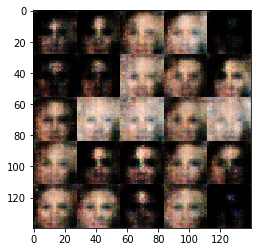

Epoch 1/1... Discriminator Loss: 0.4959 Generator Loss: 4.0697
Epoch 1/1... Discriminator Loss: 0.5631 Generator Loss: 3.3869
Epoch 1/1... Discriminator Loss: 1.2688 Generator Loss: 1.1020
Epoch 1/1... Discriminator Loss: 0.5173 Generator Loss: 2.9321
Epoch 1/1... Discriminator Loss: 0.5357 Generator Loss: 2.9118
Epoch 1/1... Discriminator Loss: 0.6271 Generator Loss: 2.3461
Epoch 1/1... Discriminator Loss: 0.5317 Generator Loss: 3.1119
Epoch 1/1... Discriminator Loss: 0.4884 Generator Loss: 3.6953
Epoch 1/1... Discriminator Loss: 0.4917 Generator Loss: 3.1668
Epoch 1/1... Discriminator Loss: 0.5140 Generator Loss: 3.2230


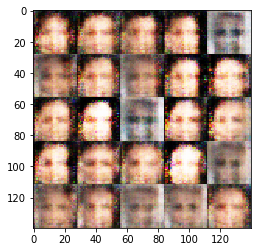

Epoch 1/1... Discriminator Loss: 0.4988 Generator Loss: 3.3196
Epoch 1/1... Discriminator Loss: 0.5508 Generator Loss: 2.7469
Epoch 1/1... Discriminator Loss: 0.9623 Generator Loss: 4.8664
Epoch 1/1... Discriminator Loss: 0.5512 Generator Loss: 2.9189
Epoch 1/1... Discriminator Loss: 0.7951 Generator Loss: 1.9282
Epoch 1/1... Discriminator Loss: 0.5350 Generator Loss: 3.4367
Epoch 1/1... Discriminator Loss: 1.1826 Generator Loss: 1.0385
Epoch 1/1... Discriminator Loss: 0.7821 Generator Loss: 3.1659
Epoch 1/1... Discriminator Loss: 0.7418 Generator Loss: 2.4012
Epoch 1/1... Discriminator Loss: 0.6751 Generator Loss: 1.8923


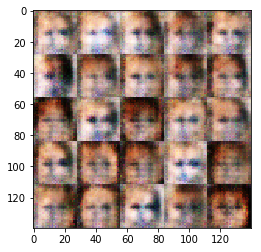

Epoch 1/1... Discriminator Loss: 0.7714 Generator Loss: 3.0770
Epoch 1/1... Discriminator Loss: 0.5334 Generator Loss: 3.3943
Epoch 1/1... Discriminator Loss: 0.9525 Generator Loss: 1.3340
Epoch 1/1... Discriminator Loss: 0.7484 Generator Loss: 1.8215
Epoch 1/1... Discriminator Loss: 0.6734 Generator Loss: 2.0399
Epoch 1/1... Discriminator Loss: 0.7842 Generator Loss: 3.1095
Epoch 1/1... Discriminator Loss: 0.8440 Generator Loss: 1.8701
Epoch 1/1... Discriminator Loss: 0.6084 Generator Loss: 2.8431
Epoch 1/1... Discriminator Loss: 0.9593 Generator Loss: 1.4906
Epoch 1/1... Discriminator Loss: 0.6217 Generator Loss: 2.5462


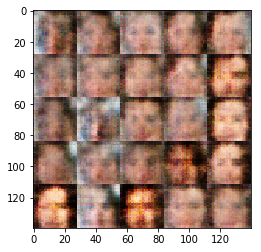

Epoch 1/1... Discriminator Loss: 0.7692 Generator Loss: 1.8919
Epoch 1/1... Discriminator Loss: 0.7632 Generator Loss: 1.6482
Epoch 1/1... Discriminator Loss: 0.6782 Generator Loss: 2.2093
Epoch 1/1... Discriminator Loss: 0.7030 Generator Loss: 3.0070
Epoch 1/1... Discriminator Loss: 0.7336 Generator Loss: 2.7763
Epoch 1/1... Discriminator Loss: 0.7534 Generator Loss: 1.7702
Epoch 1/1... Discriminator Loss: 0.7054 Generator Loss: 2.2413
Epoch 1/1... Discriminator Loss: 0.5983 Generator Loss: 2.8677
Epoch 1/1... Discriminator Loss: 0.7169 Generator Loss: 2.1955
Epoch 1/1... Discriminator Loss: 0.7956 Generator Loss: 1.6625


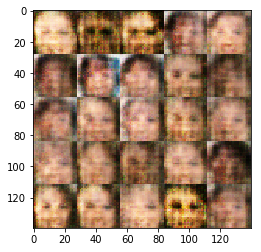

Epoch 1/1... Discriminator Loss: 0.8305 Generator Loss: 1.4650
Epoch 1/1... Discriminator Loss: 0.5709 Generator Loss: 2.2901
Epoch 1/1... Discriminator Loss: 0.6996 Generator Loss: 2.5969
Epoch 1/1... Discriminator Loss: 0.7787 Generator Loss: 2.0518
Epoch 1/1... Discriminator Loss: 0.5725 Generator Loss: 2.6182
Epoch 1/1... Discriminator Loss: 0.9090 Generator Loss: 1.4964
Epoch 1/1... Discriminator Loss: 0.8036 Generator Loss: 2.4766
Epoch 1/1... Discriminator Loss: 0.6643 Generator Loss: 2.4448
Epoch 1/1... Discriminator Loss: 0.6478 Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.8670 Generator Loss: 2.5134


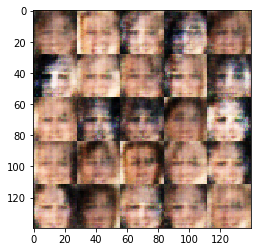

Epoch 1/1... Discriminator Loss: 0.7329 Generator Loss: 2.1642
Epoch 1/1... Discriminator Loss: 0.7602 Generator Loss: 2.6021
Epoch 1/1... Discriminator Loss: 0.7072 Generator Loss: 2.5295
Epoch 1/1... Discriminator Loss: 0.6282 Generator Loss: 2.2574
Epoch 1/1... Discriminator Loss: 0.6684 Generator Loss: 2.4473
Epoch 1/1... Discriminator Loss: 0.7627 Generator Loss: 1.9579
Epoch 1/1... Discriminator Loss: 0.7830 Generator Loss: 2.3825
Epoch 1/1... Discriminator Loss: 1.1091 Generator Loss: 1.1287
Epoch 1/1... Discriminator Loss: 0.7480 Generator Loss: 2.1224
Epoch 1/1... Discriminator Loss: 0.6986 Generator Loss: 2.6604


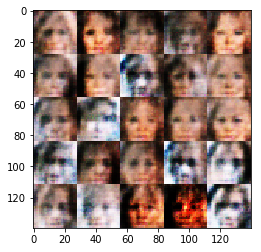

Epoch 1/1... Discriminator Loss: 0.7620 Generator Loss: 1.6176
Epoch 1/1... Discriminator Loss: 0.6931 Generator Loss: 1.8820
Epoch 1/1... Discriminator Loss: 0.6875 Generator Loss: 3.2547
Epoch 1/1... Discriminator Loss: 0.6536 Generator Loss: 2.1415
Epoch 1/1... Discriminator Loss: 0.8393 Generator Loss: 2.1122
Epoch 1/1... Discriminator Loss: 0.6073 Generator Loss: 2.6777
Epoch 1/1... Discriminator Loss: 0.6640 Generator Loss: 2.8388
Epoch 1/1... Discriminator Loss: 0.7860 Generator Loss: 2.0384
Epoch 1/1... Discriminator Loss: 0.7161 Generator Loss: 2.2988
Epoch 1/1... Discriminator Loss: 0.6787 Generator Loss: 2.3164


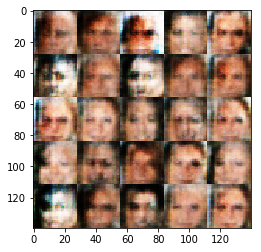

Epoch 1/1... Discriminator Loss: 0.7355 Generator Loss: 2.1920
Epoch 1/1... Discriminator Loss: 0.9021 Generator Loss: 2.1190
Epoch 1/1... Discriminator Loss: 0.7696 Generator Loss: 2.4742
Epoch 1/1... Discriminator Loss: 0.8758 Generator Loss: 1.5958
Epoch 1/1... Discriminator Loss: 0.6900 Generator Loss: 2.2390
Epoch 1/1... Discriminator Loss: 0.8751 Generator Loss: 1.9437
Epoch 1/1... Discriminator Loss: 0.7339 Generator Loss: 3.0123
Epoch 1/1... Discriminator Loss: 0.7777 Generator Loss: 2.9061
Epoch 1/1... Discriminator Loss: 0.9954 Generator Loss: 1.6577
Epoch 1/1... Discriminator Loss: 1.0783 Generator Loss: 1.2066


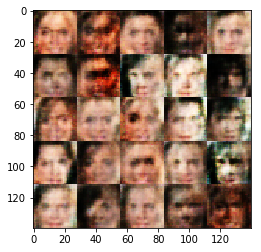

Epoch 1/1... Discriminator Loss: 0.8524 Generator Loss: 1.5180
Epoch 1/1... Discriminator Loss: 0.7763 Generator Loss: 1.8736
Epoch 1/1... Discriminator Loss: 0.6895 Generator Loss: 2.7435
Epoch 1/1... Discriminator Loss: 0.7552 Generator Loss: 2.2219
Epoch 1/1... Discriminator Loss: 0.5987 Generator Loss: 2.3984
Epoch 1/1... Discriminator Loss: 0.7910 Generator Loss: 1.7472
Epoch 1/1... Discriminator Loss: 1.0338 Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 0.9159 Generator Loss: 1.4796
Epoch 1/1... Discriminator Loss: 0.7193 Generator Loss: 1.6806
Epoch 1/1... Discriminator Loss: 0.7550 Generator Loss: 1.7950


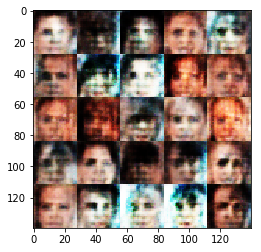

Epoch 1/1... Discriminator Loss: 0.7695 Generator Loss: 3.1004
Epoch 1/1... Discriminator Loss: 0.6419 Generator Loss: 2.8196
Epoch 1/1... Discriminator Loss: 0.7846 Generator Loss: 2.1778
Epoch 1/1... Discriminator Loss: 0.6493 Generator Loss: 2.1171
Epoch 1/1... Discriminator Loss: 0.9674 Generator Loss: 2.1791
Epoch 1/1... Discriminator Loss: 0.7579 Generator Loss: 2.4775
Epoch 1/1... Discriminator Loss: 0.7878 Generator Loss: 1.8221
Epoch 1/1... Discriminator Loss: 0.7616 Generator Loss: 2.3510
Epoch 1/1... Discriminator Loss: 0.9461 Generator Loss: 1.3794
Epoch 1/1... Discriminator Loss: 0.8821 Generator Loss: 1.7078


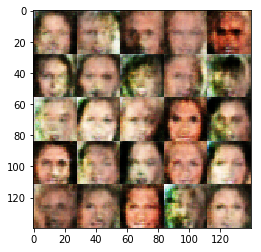

Epoch 1/1... Discriminator Loss: 0.8820 Generator Loss: 1.8825
Epoch 1/1... Discriminator Loss: 0.8151 Generator Loss: 2.1400
Epoch 1/1... Discriminator Loss: 0.7710 Generator Loss: 2.1294
Epoch 1/1... Discriminator Loss: 0.8678 Generator Loss: 1.4381
Epoch 1/1... Discriminator Loss: 0.8846 Generator Loss: 1.4908
Epoch 1/1... Discriminator Loss: 0.9327 Generator Loss: 1.8902
Epoch 1/1... Discriminator Loss: 0.7919 Generator Loss: 1.9121
Epoch 1/1... Discriminator Loss: 1.0252 Generator Loss: 1.7050
Epoch 1/1... Discriminator Loss: 0.8513 Generator Loss: 1.6883
Epoch 1/1... Discriminator Loss: 0.8137 Generator Loss: 1.6516


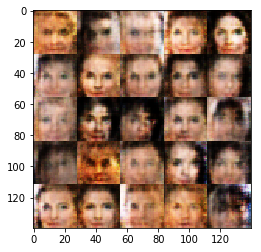

Epoch 1/1... Discriminator Loss: 0.7244 Generator Loss: 2.1498
Epoch 1/1... Discriminator Loss: 0.8800 Generator Loss: 1.7619
Epoch 1/1... Discriminator Loss: 0.8723 Generator Loss: 2.5929
Epoch 1/1... Discriminator Loss: 0.9040 Generator Loss: 2.2310
Epoch 1/1... Discriminator Loss: 1.0382 Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 0.8731 Generator Loss: 1.8511
Epoch 1/1... Discriminator Loss: 0.7393 Generator Loss: 2.0667
Epoch 1/1... Discriminator Loss: 0.9364 Generator Loss: 1.5402
Epoch 1/1... Discriminator Loss: 1.0146 Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.7460 Generator Loss: 2.3671


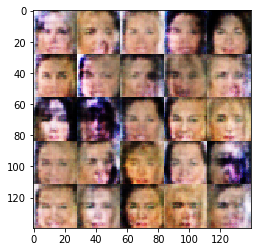

Epoch 1/1... Discriminator Loss: 0.7911 Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 0.7624 Generator Loss: 2.2089
Epoch 1/1... Discriminator Loss: 0.9256 Generator Loss: 1.7239
Epoch 1/1... Discriminator Loss: 0.8433 Generator Loss: 2.0116
Epoch 1/1... Discriminator Loss: 0.8435 Generator Loss: 2.4970
Epoch 1/1... Discriminator Loss: 0.8265 Generator Loss: 2.0594
Epoch 1/1... Discriminator Loss: 0.8028 Generator Loss: 1.8701
Epoch 1/1... Discriminator Loss: 0.7376 Generator Loss: 2.4732
Epoch 1/1... Discriminator Loss: 0.8095 Generator Loss: 1.8399
Epoch 1/1... Discriminator Loss: 0.9983 Generator Loss: 1.6963


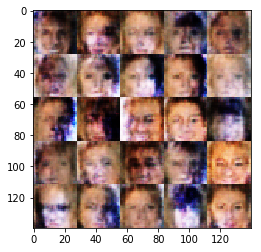

Epoch 1/1... Discriminator Loss: 1.0934 Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 0.8290 Generator Loss: 2.4415
Epoch 1/1... Discriminator Loss: 0.8205 Generator Loss: 2.3764
Epoch 1/1... Discriminator Loss: 0.8371 Generator Loss: 1.8957
Epoch 1/1... Discriminator Loss: 0.9167 Generator Loss: 1.4451
Epoch 1/1... Discriminator Loss: 0.7613 Generator Loss: 2.0983
Epoch 1/1... Discriminator Loss: 1.1312 Generator Loss: 2.0735
Epoch 1/1... Discriminator Loss: 0.8647 Generator Loss: 1.3480
Epoch 1/1... Discriminator Loss: 0.8469 Generator Loss: 1.6993
Epoch 1/1... Discriminator Loss: 1.0214 Generator Loss: 2.4551


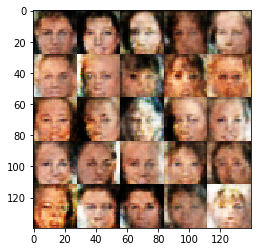

Epoch 1/1... Discriminator Loss: 0.9002 Generator Loss: 1.8043
Epoch 1/1... Discriminator Loss: 0.9536 Generator Loss: 1.2838
Epoch 1/1... Discriminator Loss: 0.7045 Generator Loss: 2.1899
Epoch 1/1... Discriminator Loss: 0.7762 Generator Loss: 2.3656
Epoch 1/1... Discriminator Loss: 0.6845 Generator Loss: 2.0162
Epoch 1/1... Discriminator Loss: 0.8321 Generator Loss: 2.0634
Epoch 1/1... Discriminator Loss: 0.9151 Generator Loss: 1.4443
Epoch 1/1... Discriminator Loss: 0.8757 Generator Loss: 2.5504
Epoch 1/1... Discriminator Loss: 0.8253 Generator Loss: 1.7099
Epoch 1/1... Discriminator Loss: 0.7684 Generator Loss: 2.1201


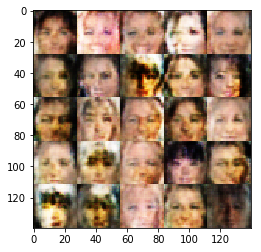

Epoch 1/1... Discriminator Loss: 0.7647 Generator Loss: 2.3002
Epoch 1/1... Discriminator Loss: 0.8438 Generator Loss: 1.8358
Epoch 1/1... Discriminator Loss: 0.8916 Generator Loss: 2.3499
Epoch 1/1... Discriminator Loss: 0.8043 Generator Loss: 2.2767
Epoch 1/1... Discriminator Loss: 0.7670 Generator Loss: 2.2867
Epoch 1/1... Discriminator Loss: 0.9555 Generator Loss: 1.3448
Epoch 1/1... Discriminator Loss: 0.9349 Generator Loss: 1.3415
Epoch 1/1... Discriminator Loss: 0.7744 Generator Loss: 1.8232
Epoch 1/1... Discriminator Loss: 0.7183 Generator Loss: 2.1966
Epoch 1/1... Discriminator Loss: 0.8299 Generator Loss: 1.4819


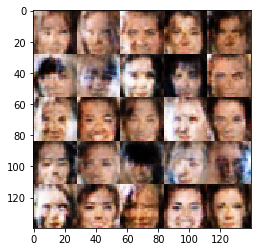

Epoch 1/1... Discriminator Loss: 0.8468 Generator Loss: 2.1033
Epoch 1/1... Discriminator Loss: 0.8164 Generator Loss: 1.9488
Epoch 1/1... Discriminator Loss: 0.7926 Generator Loss: 2.0165
Epoch 1/1... Discriminator Loss: 1.0047 Generator Loss: 1.4875
Epoch 1/1... Discriminator Loss: 0.8334 Generator Loss: 2.1634
Epoch 1/1... Discriminator Loss: 0.9759 Generator Loss: 3.3049
Epoch 1/1... Discriminator Loss: 1.0355 Generator Loss: 1.4933
Epoch 1/1... Discriminator Loss: 0.8892 Generator Loss: 1.8251
Epoch 1/1... Discriminator Loss: 0.8227 Generator Loss: 1.6301
Epoch 1/1... Discriminator Loss: 0.9020 Generator Loss: 1.4941


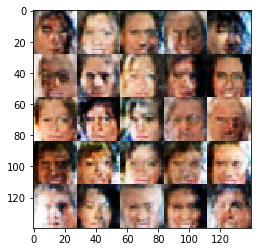

Epoch 1/1... Discriminator Loss: 0.9629 Generator Loss: 2.2614
Epoch 1/1... Discriminator Loss: 0.8698 Generator Loss: 1.8422
Epoch 1/1... Discriminator Loss: 0.9937 Generator Loss: 1.4669
Epoch 1/1... Discriminator Loss: 0.8169 Generator Loss: 2.1408
Epoch 1/1... Discriminator Loss: 0.9878 Generator Loss: 1.2771
Epoch 1/1... Discriminator Loss: 0.9491 Generator Loss: 1.1146
Epoch 1/1... Discriminator Loss: 0.8426 Generator Loss: 2.1260
Epoch 1/1... Discriminator Loss: 0.8381 Generator Loss: 1.8691
Epoch 1/1... Discriminator Loss: 0.8658 Generator Loss: 1.5825
Epoch 1/1... Discriminator Loss: 0.8756 Generator Loss: 2.0247


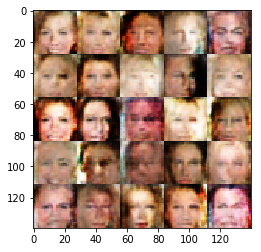

Epoch 1/1... Discriminator Loss: 0.8400 Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 0.9938 Generator Loss: 1.4721
Epoch 1/1... Discriminator Loss: 0.9684 Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.9725 Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 0.8817 Generator Loss: 1.5752
Epoch 1/1... Discriminator Loss: 0.8191 Generator Loss: 1.7006
Epoch 1/1... Discriminator Loss: 0.7915 Generator Loss: 2.1916
Epoch 1/1... Discriminator Loss: 0.8401 Generator Loss: 1.9448
Epoch 1/1... Discriminator Loss: 0.8617 Generator Loss: 1.9041
Epoch 1/1... Discriminator Loss: 0.8271 Generator Loss: 1.5588


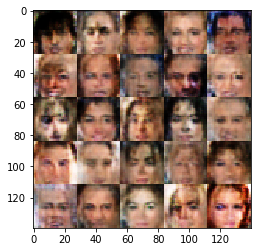

Epoch 1/1... Discriminator Loss: 0.8418 Generator Loss: 1.4166
Epoch 1/1... Discriminator Loss: 0.9207 Generator Loss: 1.8938
Epoch 1/1... Discriminator Loss: 0.7640 Generator Loss: 2.4186
Epoch 1/1... Discriminator Loss: 0.9267 Generator Loss: 1.9516
Epoch 1/1... Discriminator Loss: 0.8597 Generator Loss: 2.3682
Epoch 1/1... Discriminator Loss: 0.7461 Generator Loss: 2.3627
Epoch 1/1... Discriminator Loss: 0.8210 Generator Loss: 1.8064
Epoch 1/1... Discriminator Loss: 0.7564 Generator Loss: 2.3508
Epoch 1/1... Discriminator Loss: 0.9994 Generator Loss: 1.3740
Epoch 1/1... Discriminator Loss: 0.6762 Generator Loss: 2.2105


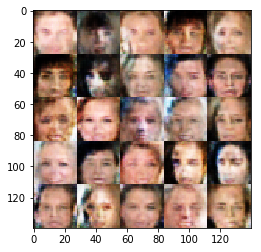

Epoch 1/1... Discriminator Loss: 0.8826 Generator Loss: 2.1711
Epoch 1/1... Discriminator Loss: 0.8565 Generator Loss: 1.4593
Epoch 1/1... Discriminator Loss: 1.0003 Generator Loss: 1.4390
Epoch 1/1... Discriminator Loss: 0.8405 Generator Loss: 2.1695
Epoch 1/1... Discriminator Loss: 0.9165 Generator Loss: 1.3785
Epoch 1/1... Discriminator Loss: 0.7121 Generator Loss: 1.9134
Epoch 1/1... Discriminator Loss: 0.8079 Generator Loss: 1.9113
Epoch 1/1... Discriminator Loss: 0.7032 Generator Loss: 1.7480
Epoch 1/1... Discriminator Loss: 0.9123 Generator Loss: 1.8236
Epoch 1/1... Discriminator Loss: 0.8396 Generator Loss: 1.8023


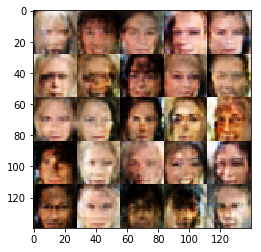

Epoch 1/1... Discriminator Loss: 0.7962 Generator Loss: 1.9181
Epoch 1/1... Discriminator Loss: 0.9542 Generator Loss: 1.0301
Epoch 1/1... Discriminator Loss: 0.9112 Generator Loss: 1.8747
Epoch 1/1... Discriminator Loss: 0.9310 Generator Loss: 1.7075
Epoch 1/1... Discriminator Loss: 0.8368 Generator Loss: 1.7486
Epoch 1/1... Discriminator Loss: 1.0790 Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.7314 Generator Loss: 1.5278
Epoch 1/1... Discriminator Loss: 0.7533 Generator Loss: 1.7736
Epoch 1/1... Discriminator Loss: 0.8971 Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 0.8562 Generator Loss: 1.6479


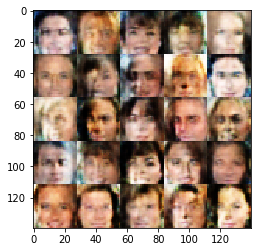

Epoch 1/1... Discriminator Loss: 0.8550 Generator Loss: 1.4298
Epoch 1/1... Discriminator Loss: 0.8052 Generator Loss: 1.5892
Epoch 1/1... Discriminator Loss: 0.7387 Generator Loss: 2.0996
Epoch 1/1... Discriminator Loss: 0.7370 Generator Loss: 1.6397
Epoch 1/1... Discriminator Loss: 0.9998 Generator Loss: 1.6398
Epoch 1/1... Discriminator Loss: 0.7437 Generator Loss: 2.2788


In [39]:
batch_size = 64
z_dim = 125
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.